In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# download training and test data from open datasets
training_data = datasets.FashionMNIST(
    root="data", 
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.FashionMNIST(
    root="data", 
    train=False,
    download=True,
    transform=ToTensor())

# create data loaders
batch_size = 64
train_dataloader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True)
test_dataloader = DataLoader(test_data,
                            batch_size=batch_size)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class ConvAutoencoder(nn.Module): 
    def __init__(self, encoded_space_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride = 2, padding=1),
            nn.ReLU(),

            nn.Conv2d(8, 16, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride = 2, padding=0),
            nn.ReLU(),

            nn.Flatten(start_dim=1),
            nn.Linear(3*3*32, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_space_dim)
        )
        self.decoder = nn.Sequential(            
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3*3*32),
            nn.ReLU(),

            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),

            nn.ConvTranspose2d(32, 16, 5, stride=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 5, stride=1, padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(8, 4, 3, stride=2, padding=2, output_padding=0),
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.ConvTranspose2d(4, 1, 3, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder(encoded_space_dim=64).to(device)
summary(model, input_size=(64, 1, 28, 28))

Using cuda device


Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoencoder                          [64, 1, 28, 28]           --
├─Sequential: 1-1                        [64, 64]                  --
│    └─Conv2d: 2-1                       [64, 8, 14, 14]           80
│    └─ReLU: 2-2                         [64, 8, 14, 14]           --
│    └─Conv2d: 2-3                       [64, 16, 7, 7]            1,168
│    └─BatchNorm2d: 2-4                  [64, 16, 7, 7]            32
│    └─ReLU: 2-5                         [64, 16, 7, 7]            --
│    └─Conv2d: 2-6                       [64, 32, 3, 3]            4,640
│    └─ReLU: 2-7                         [64, 32, 3, 3]            --
│    └─Flatten: 2-8                      [64, 288]                 --
│    └─Linear: 2-9                       [64, 128]                 36,992
│    └─ReLU: 2-10                        [64, 128]                 --
│    └─Linear: 2-11                      [64, 64]                  8,256
├─

In [4]:
### TRAINING

# tensorboard writer
writer = SummaryWriter()

loss_fn = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer, verbose=False, epoch=0):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        
        # compute reconstruction error
        reconstructed = model(X)
        loss = loss_fn(reconstructed, X)

        # compute grads and optimize model params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # write to tensorboard
        writer.add_scalar("Train Loss", loss.item(), batch + epoch*len(dataloader))
         
        if verbose and batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"mean loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [5]:
def test(dataloader, model, loss_fn, epoch=0):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            reconstructed = model(X)
            test_loss += loss_fn(reconstructed, X).item()
    test_loss /= num_batches
    # write to tensorboard
    writer.add_scalar("Test Loss", test_loss, epoch)
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [6]:
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n----------------------------")
    train(train_dataloader, model, loss_fn, optimizer, epoch=epoch)
    test(test_dataloader, model, loss_fn, epoch=epoch)
print("Done!")

Epoch 1
----------------------------
Test Error: 
 Avg loss: 0.029258 

Epoch 2
----------------------------
Test Error: 
 Avg loss: 0.018446 

Epoch 3
----------------------------
Test Error: 
 Avg loss: 0.015371 

Epoch 4
----------------------------
Test Error: 
 Avg loss: 0.013758 

Epoch 5
----------------------------
Test Error: 
 Avg loss: 0.012522 

Epoch 6
----------------------------
Test Error: 
 Avg loss: 0.012290 

Epoch 7
----------------------------
Test Error: 
 Avg loss: 0.011894 

Epoch 8
----------------------------
Test Error: 
 Avg loss: 0.011190 

Epoch 9
----------------------------
Test Error: 
 Avg loss: 0.011317 

Epoch 10
----------------------------
Test Error: 
 Avg loss: 0.010839 

Epoch 11
----------------------------
Test Error: 
 Avg loss: 0.010539 

Epoch 12
----------------------------
Test Error: 
 Avg loss: 0.010595 

Epoch 13
----------------------------
Test Error: 
 Avg loss: 0.010411 

Epoch 14
----------------------------
Test Error: 
 Avg loss

<Figure size 640x480 with 0 Axes>

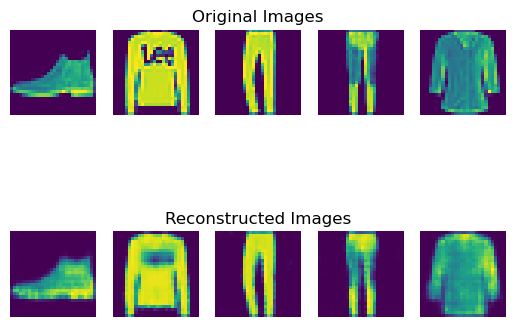

In [7]:
test_images = 5
plt.figure()
f, axarr = plt.subplots(2, test_images) 
axarr[0, 2].set_title("Original Images")
axarr[1, 2].set_title("Reconstructed Images")

model.eval()
with torch.no_grad():
    for i in range(test_images):
        axarr[0][i].axis("off")
        axarr[1][i].axis("off")

        # original images
        x, y = test_data[i][0], test_data[i][1]
        axarr[0, i].imshow(x.permute(1, 2, 0)) # permute tensor to be channels last
        # reconstructed images
        x = x.unsqueeze(0).to(device)
        reconstructed = model(x)
        axarr[1, i].imshow(reconstructed[0].cpu().permute(1, 2, 0))

In [8]:
torch.save(model.state_dict(), "conv_autoencoder.pth")
print("Saved PyTorch Model State to conv_autoencoder.pth")

Saved PyTorch Model State to conv_autoencoder.pth


In [ ]:
# we need to recreate the model structure and then load the state dictionary into it
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load("conv_autoencoder.pth"))